#  GP latent function inference

This notebook uses GP to infer a latent function $\lambda(x)$, which parameterises the exponential distribution:
$$(y_1, y_2) \sim GaussianCopula(\lambda),$$
where:
$$\lambda = (2 \cdot \Phi(f) - 1) \in (-1,+1)$$
is a GP link function, which transforms the latent gaussian process variable:
$$f \sim GP \in (-\infty,+\infty).$$

In [2]:
import math
import torch
import pyro
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

from bvcopula import GaussianCopula, GaussianCopula_Likelihood, GaussianCopula_Flow_Likelihood, \
GPInferenceModel, KISS_GPInferenceModel

pyro.enable_validation(True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [82]:
#here we specify a 'true' latent function lambda
scale = lambda x: .99+0.*x#np.sin(2*np.pi*1*x)*np.sin(2*np.pi*3*x+.6)*1.+0.0 #*np.sin(2*np.pi*3*x+.6)

(10000, 2)


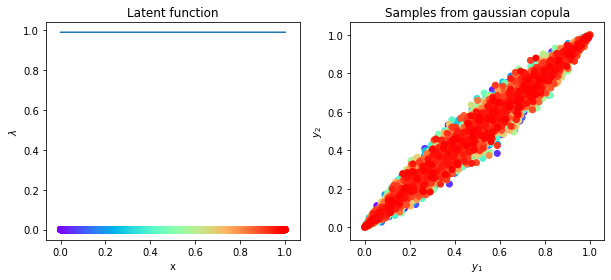

In [83]:
# here we generate some synthetic samples
from starvine.bvcopula.copula.gauss_copula import GaussCopula
import matplotlib.cm as cm

NSamp = 1e4

X = np.linspace(0,1,NSamp) 

fig, (lambdaf, samples) = plt.subplots(1,2,figsize=(10,4))

lambdaf.plot(X,scale(X))
lambdaf.set_xlabel('x')
lambdaf.set_ylabel('$\lambda$')
lambdaf.set_title('Latent function')

# Y = np.zeros((NSamp,2))
# copula = GaussCopula()
# for i,x in enumerate(X):
#     if scale(x) == 0:
#         Y[i] = np.random.uniform(low=0,high=1,size=2)
#     else:
#         Y[i] = np.array(copula.sample(1,scale(x))).T # size=1
scales = [scale(x) for x in X]
model = GaussianCopula(torch.tensor(scales).float())
Y = model.sample().numpy().squeeze()
print(Y.shape)
colors = cm.rainbow(np.linspace(0, 1, NSamp))
lambdaf.scatter(X,np.zeros_like(X),color=colors)
samples.scatter(*Y.T, color=colors)
samples.set_xlabel('$y_1$')
samples.set_ylabel('$y_2$')
samples.set_title('Samples from gaussian copula')

fig.show()

In [84]:
#convert numpy data to tensors (optionally on GPU)
train_x = torch.tensor(X).float().cuda(device=0)
train_y = torch.tensor(Y).float().cuda(device=0)

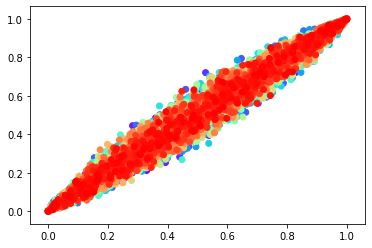

In [85]:
vec_scale = np.vectorize(scale)
scales = vec_scale(X)
m = GaussianCopula(torch.tensor(scales).float())#torch.ones(100)*0.7)
plt.scatter(*m.sample().numpy().T,color=colors)

In [86]:
class KISS_GPInferenceModel2(gpytorch.models.PyroVariationalGP):
    def __init__(self, likelihood, prior_rbf_length=0.1, grid_size=128, grid_bounds=[(0, 1)], name_prefix="mixture_gp"):
        # Define all the variational stuff
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(grid_size)
        variational_strategy = gpytorch.variational.GridInterpolationVariationalStrategy(
            self, grid_size, grid_bounds, variational_distribution
        )
        
        # Standard initializtation
        super(KISS_GPInferenceModel2, self).__init__(variational_strategy, likelihood, num_data=grid_size) #?
        self.likelihood = likelihood
        
        # Mean, covar
        self.mean_module = gpytorch.means.ConstantMean()
        
        #we specify prior here
        lengthscale_prior = gpytorch.priors.NormalPrior(prior_rbf_length, 1.0) #variance does not matter much
        
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=1.5, lengthscale_prior=lengthscale_prior)
            #gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior),
        )
        
        # Initialize lengthscale and outputscale to mean of priors
        self.covar_module.base_kernel.lengthscale = lengthscale_prior.mean
        #self.covar_module.outputscale = outputscale_prior.mean

    def forward(self, x):
        mean = self.mean_module(x)  # Returns an n_data vec
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [92]:
# define the model (optionally on GPU)
grid_size = 128
#model = GPInferenceModel(train_x, train_y, GaussianCopula_Likelihood())#.cuda(device=0)
model = KISS_GPInferenceModel2(GaussianCopula_Likelihood(), prior_rbf_length=0.7, grid_size=grid_size).cuda(device=0)

In [93]:
# train the model
from pyro import optim

base_lr = 1e-3
iter_print = 100

print('Basic lr for most of parameters: {}'.format(base_lr))

# set learning rates for different hyperparameters
def per_param_callable(module_name, param_name):
    if param_name == 'covar_module.base_kernel.raw_lengthscale':
        return {"lr": .05} #.1 for 256 particles
    elif param_name == 'variational_strategy.variational_distribution.variational_mean':
        return {"lr": .1}
    else:
        return {"lr": base_lr}

# Use the adam optimizer
optimizer = optim.Adam(per_param_callable)

pyro.clear_param_store() # clean run

losses, rbf = [], []

def train(num_iter=3000):
    elbo = pyro.infer.Trace_ELBO(num_particles=128, vectorize_particles=True, max_plate_nesting=1)
    svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)
    model.train()

    p = 0.
    for i in range(num_iter):
        model.zero_grad()
        loss = svi.step(train_x, train_y)
        if len(losses)>100: 
            p += np.abs(np.mean(losses[-50:]) - np.mean(losses[-100:-50]))
        losses.append(loss)
        rbf.append(model.covar_module.base_kernel.lengthscale.item())
        if not (i + 1) % iter_print:
            mean_p = p/100
            print('Iter {}/{} - Loss: {:.3}   lengthscale: {:.3}, dLoss: {:.3}'.format(
                i + 1, num_iter, loss,
                model.covar_module.base_kernel.lengthscale.item(), mean_p/np.abs(loss)
            ))
            #print(np.std(losses[-100:]))
            if (0 < mean_p/np.abs(loss) < 0.01): 
                print("Converged!")
                break
            p = 0.
        
%time train()

Basic lr for most of parameters: 0.001
Iter 100/3000 - Loss: -25.6   lengthscale: 0.564, dLoss: 0.0
Iter 200/3000 - Loss: -80.2   lengthscale: 0.587, dLoss: 0.528
Iter 300/3000 - Loss: -1.26e+02   lengthscale: 0.605, dLoss: 0.201
Iter 400/3000 - Loss: -1.54e+02   lengthscale: 0.625, dLoss: 0.12
Iter 500/3000 - Loss: -1.73e+02   lengthscale: 0.648, dLoss: 0.0631
Iter 600/3000 - Loss: -1.89e+02   lengthscale: 0.674, dLoss: 0.0464
Iter 700/3000 - Loss: -2.01e+02   lengthscale: 0.704, dLoss: 0.0346
Iter 800/3000 - Loss: -2.1e+02   lengthscale: 0.736, dLoss: 0.0251
Iter 900/3000 - Loss: -2.17e+02   lengthscale: 0.767, dLoss: 0.0166
Iter 1000/3000 - Loss: -2.21e+02   lengthscale: 0.799, dLoss: 0.013
Iter 1100/3000 - Loss: -2.25e+02   lengthscale: 0.831, dLoss: 0.00953
Converged!
CPU times: user 7min 12s, sys: 8.23 s, total: 7min 20s
Wall time: 58.1 s


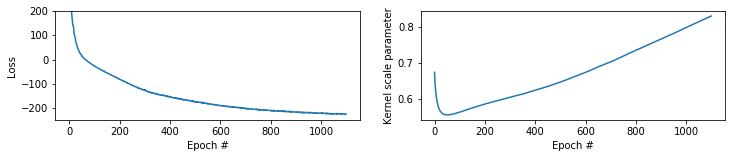

In [94]:
# prot loss function and kernel length
fig, (loss, kern) = plt.subplots(1,2,figsize=(12,2))
loss.plot(losses)
loss.set_xlabel("Epoch #")
loss.set_ylabel("Loss")
loss.set_ylim(np.min(losses)*1.1,200)
kern.plot(rbf)
kern.set_xlabel("Epoch #")
kern.set_ylabel("Kernel scale parameter")
fig.show()

In [95]:
# define test set (optionally on GPU)
denser = 2 # make test set 2 times denser then the training set
testX = np.linspace(0,1,denser*NSamp)
test_x = torch.tensor(testX).float().cuda(device=0)

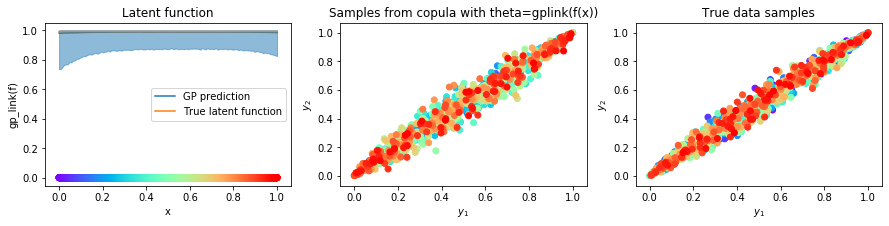

In [100]:
# visualize the result
fig, (func, sim, true) = plt.subplots(1,3,figsize=(15, 3))

model.eval()
with torch.no_grad():
    output = model(test_x)
    
gplink = model.likelihood.gplink_function
 
#samples = output.rsample(torch.Size([2048]))
#F_mean = gplink(samples).mean(0).detach().cpu().numpy()
F_mean = gplink(output.mean).detach().cpu().numpy()
line, = func.plot(testX, F_mean, label = 'GP prediction')
lower, upper = output.confidence_region()
func.fill_between(testX, gplink(lower).detach().cpu().numpy(),
                gplink(upper).detach().cpu().numpy(), color=line.get_color(), alpha=0.5)

func.plot(testX,scale(testX), label = 'True latent function')
func.scatter(X,np.zeros_like(X),color=colors)
func.set_xlabel('x')
func.set_ylabel('gp_link(f)')
func.set_title('Latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) (doubly stochastic)
with gpytorch.settings.num_likelihood_samples(1):
    Y_sim = model.likelihood(model(train_x)).rsample().cpu().detach().numpy()
skip = 10
true.scatter(*Y[::skip].T, label = 'True train data', color=colors[::skip])
sim.scatter(*Y_sim[:,:,::skip].T, label = 'Sample from the model', color=colors[::skip])
for ax in [sim,true]:
    ax.set_xlabel('$y_1$')
    ax.set_ylabel('$y_2$')
sim.set_title('Samples from copula with theta=gplink(f(x))')
true.set_title('True data samples')
# samp.legend()

fig.show()